In [150]:
import matplotlib.pyplot as plt
import sys 

from math import ceil 

import numpy as np

from scipy.io import savemat, loadmat
from scipy.signal import resample
from scipy.interpolate import interp1d

from operator import itemgetter

In [151]:
def smooth(x,window_len,window):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [166]:
filename = '../../../datasets/Data_27012021_noisy/benchmark/torque_step_0-100_50Hz_closed_loop.mat'
data = loadmat(filename)

In [167]:
speed = data['ans'][:, 0]
torque = data['ans'][:, 1]
var_q = data['ans'][:, 2]
var_d = data['ans'][:, 3]
time = np.arange(0, var_d.shape[0] * 0.002, 0.002)

In [168]:
current_q = []
current_q_time = []
voltage_q = []
voltage_q_time = []

w = 50

for i in range(0, var_q.shape[0], w):
    curr_idx = np.where(var_q[i:i+w] < np.mean(var_q[i:i+w]))[0]
    volt_idx = np.where(var_q[i:i+w] >= np.mean(var_q[i:i+w]))[0]
    
    if len(curr_idx) == 0:
        current_q_time += list(time[i:i+w][volt_idx])
        current_q += list(var_q[i:i+w][volt_idx])
        voltage_q_time += list(time[i:i+w][volt_idx])
        voltage_q += list(var_q[i:i+w][volt_idx])
    elif len(volt_idx) == 0:
        current_q_time += list(time[i:i+w][curr_idx])
        current_q += list(var_q[i:i+w][curr_idx])
        voltage_q_time += list(time[i:i+w][curr_idx])
        voltage_q += list(var_q[i:i+w][curr_idx])
    else:
        current_q_time += list(time[i:i+w][curr_idx])
        current_q += list(var_q[i:i+w][curr_idx])
        voltage_q_time += list(time[i:i+w][volt_idx])
        voltage_q += list(var_q[i:i+w][volt_idx])
        
        
current_d = []
current_d_time = []
voltage_d = []
voltage_d_time = []

for i in range(0, var_d.shape[0], w):
    curr_idx = np.where(var_d[i:i+w] < np.mean(var_d[i:i+w]))[0]
    volt_idx = np.where(var_d[i:i+w] >= np.mean(var_d[i:i+w]))[0]
    
    if len(curr_idx) == 0:
        current_d_time += list(time[i:i+w][volt_idx])
        current_d += list(var_d[i:i+w][volt_idx])
        voltage_d_time += list(time[i:i+w][volt_idx])
        voltage_d += list(var_d[i:i+w][volt_idx])
    elif len(volt_idx) == 0:
        current_d_time += list(time[i:i+w][curr_idx])
        current_d += list(var_d[i:i+w][curr_idx])
        voltage_d_time += list(time[i:i+w][curr_idx])
        voltage_d += list(var_d[i:i+w][curr_idx])
    else:
        current_d_time += list(time[i:i+w][curr_idx])
        current_d += list(var_d[i:i+w][curr_idx])
        voltage_d_time += list(time[i:i+w][volt_idx])
        voltage_d += list(var_d[i:i+w][volt_idx])
        
current_d = np.asarray(current_d)
voltage_d = np.asarray(voltage_d)

current_q = np.asarray(current_q)
voltage_q = np.asarray(voltage_q)

current_d_time = np.asarray(current_d_time)
voltage_d_time = np.asarray(voltage_d_time)

current_q_time = np.asarray(current_q_time)
voltage_q_time = np.asarray(voltage_q_time)

In [169]:
def ResampleLinear1D(original, targetLen):
    original = np.array(original, dtype=np.float)
    index_arr = np.linspace(0, len(original)-1, num=targetLen, dtype=np.float)
    index_floor = np.array(index_arr, dtype=np.int) #Round down
    index_ceil = index_floor + 1
    index_rem = index_arr - index_floor #Remain

    val1 = original[index_floor]
    val2 = original[index_ceil % len(original)]
    interp = val1 * (1.0-index_rem) + val2 * index_rem
    assert(len(interp) == targetLen)
    return interp

In [170]:
f = interp1d(np.arange(current_d_time.shape[0]), current_d, 'quadratic')
current_d = ResampleLinear1D(current_d, time.shape[0])

f = interp1d(np.arange(current_q_time.shape[0]), current_q, 'quadratic')
current_q = ResampleLinear1D(current_q, time.shape[0])

f = interp1d(np.arange(voltage_d_time.shape[0]), voltage_d, 'quadratic')
voltage_d = ResampleLinear1D(voltage_d, time.shape[0])

f = interp1d(np.arange(voltage_q_time.shape[0]), voltage_q, 'quadratic')
voltage_q = ResampleLinear1D(voltage_q, time.shape[0])

w = 51
w_t = "hamming"
denoised_speed = smooth(speed, window_len=w, window=w_t)[w//2:-1*w//2+1]
denoised_torque = smooth(torque, window_len=w, window=w_t)[w//2:-1*w//2+1]

<ipython-input-169-40ee879e793f>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  original = np.array(original, dtype=np.float)
<ipython-input-169-40ee879e793f>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_arr = np.linspace(0, len(original)-1, num=targetLen, dtype=np.float)
<ipython-input-169-40ee879e793f>:4: DeprecationWarning:

Text(0.5, 1.0, '$u_q$')

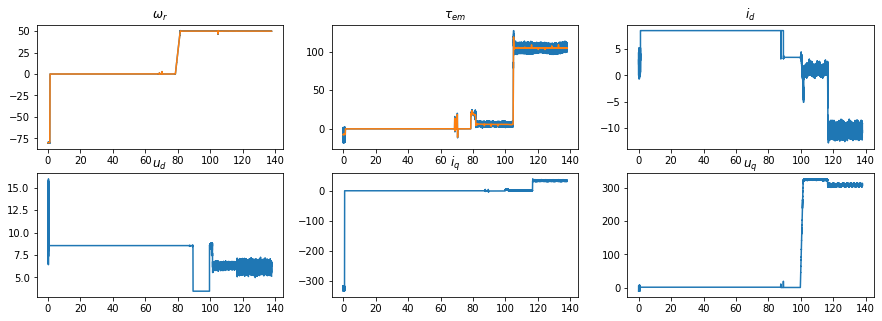

In [171]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(2, 3, 1)
plt.plot(time, speed, label='Raw')
plt.plot(time, denoised_speed, label='Recon')
plt.title(r"$\omega_r$")
plt.subplot(2, 3, 2)
plt.plot(time, torque, label='Raw')
plt.plot(time, denoised_torque, label='Recon')
plt.title(r"$\tau_{em}$")
plt.subplot(2, 3, 3)
plt.plot(time, current_d)
plt.title(r"$i_d$")
plt.subplot(2, 3, 4)
plt.plot(time, voltage_d)
plt.title(r"$u_d$")
plt.subplot(2, 3, 5)
plt.plot(time, current_q)
plt.title(r"$i_q$")
plt.subplot(2, 3, 6)
plt.plot(time, voltage_q)
plt.title(r"$u_q$")

In [172]:
savemat(filename.replace('.mat','_mod.mat'),
       {'noisy_speed': speed, 'noisy_torque': torque, 
        'noisy_current_d': current_d, 'noisy_voltage_d': voltage_d, 
        'noisy_current_q': current_q, 'noisy_voltage_q': voltage_q, 
        'speed': speed, 'torque': torque, 'time': time})